In [ ]:
#Allocating GPU for the models resource

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
import numpy as np

IMAGE_SIZE = 256
BATCH_SIZE = 8
CHANNELS = 3
EPOCHS = 50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3000 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(8, 256, 256, 3)
[1 0 0 1 1 0 0 1]


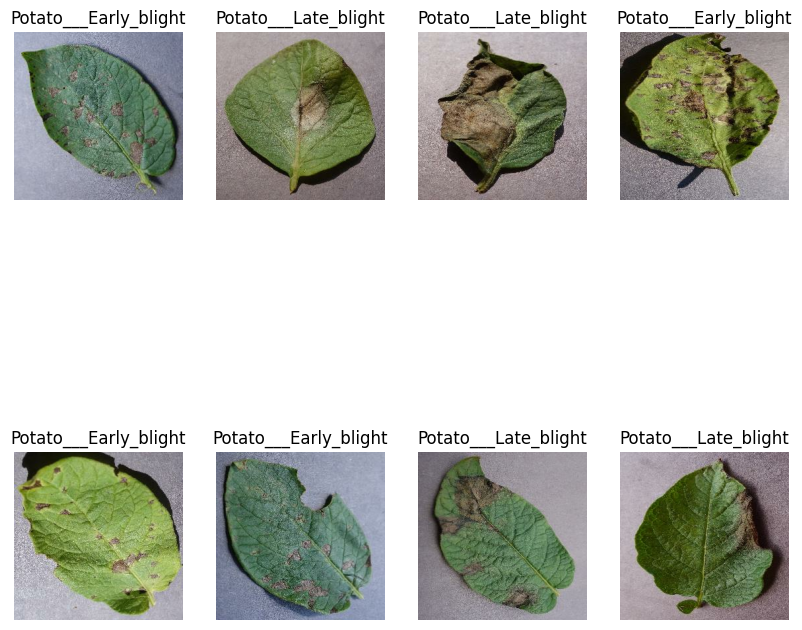

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

375

In [ ]:
train_size = 0.8
len(dataset)*train_size

300.0

In [ ]:
train_ds = dataset.take(300)
len(train_ds)

300

In [ ]:
test_ds = dataset.skip(300)
len(test_ds)

75

In [ ]:
val_size=0.1
len(dataset)*val_size

37.5

In [ ]:
val_ds = test_ds.take(37)
len(val_ds)

37

In [ ]:
test_ds = test_ds.skip(37)
len(test_ds)

38

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
print("Training Dataset Size: ", len(train_ds))
print("Validation Dataset Size: ", len(val_ds))
print("Test Dataset Size: ", len(test_ds))

Training Dataset Size:  300
Validation Dataset Size:  37
Test Dataset Size:  38


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    layers.experimental.preprocessing.RandomContrast(0.2)
])

In [ ]:
from tensorflow.keras.applications import InceptionV3

IMAGE_SIZE = 256
BATCH_SIZE = 8
CHANNELS = 3
EPOCHS = 50
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

base_model = InceptionV3(include_top = False, weights = 'imagenet', input_shape = input_shape)

for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    base_model,

    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                      

In [ ]:
model.compile(
    optimizer='rmsprop',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
300/300 [==============================] - 194s 511ms/step - loss: 0.7284 - accuracy: 0.7358 - val_loss: 0.2433 - val_accuracy: 0.9088
Epoch 2/50
300/300 [==============================] - 104s 347ms/step - loss: 0.3974 - accuracy: 0.8479 - val_loss: 0.2600 - val_accuracy: 0.8885
Epoch 3/50
300/300 [==============================] - 74s 248ms/step - loss: 0.3150 - accuracy: 0.8825 - val_loss: 0.3445 - val_accuracy: 0.8547
Epoch 4/50
300/300 [==============================] - 62s 208ms/step - loss: 0.2968 - accuracy: 0.8917 - val_loss: 0.2314 - val_accuracy: 0.8919
Epoch 5/50
300/300 [==============================] - 65s 216ms/step - loss: 0.2760 - accuracy: 0.8954 - val_loss: 0.2577 - val_accuracy: 0.8953
Epoch 6/50
300/300 [==============================] - 79s 265ms/step - loss: 0.2838 - accuracy: 0.8975 - val_loss: 0.1331 - val_accuracy: 0.9459
Epoch 7/50
300/300 [==============================] - 93s 309ms/step - loss: 0.2326 - accuracy: 0.9146 - val_loss: 0.3175 - val_

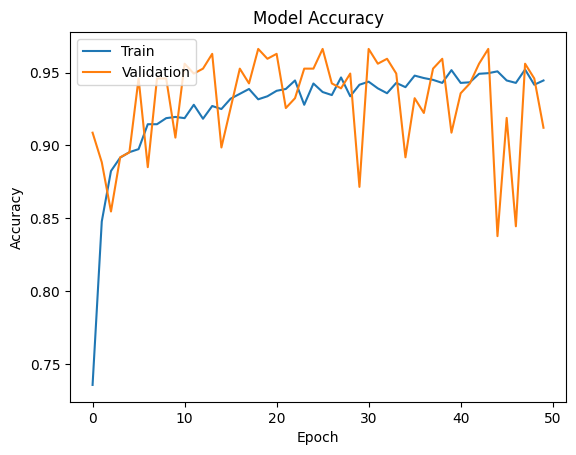

In [ ]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
except NameError:
    print("Variable 'history' is not defined. Please make sure you have executed the cell that defines this variable.")

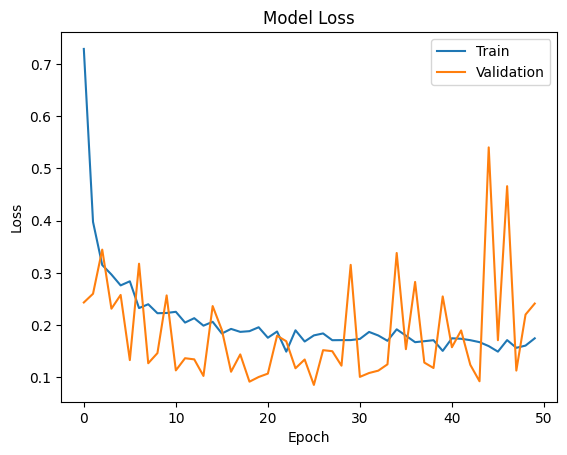

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

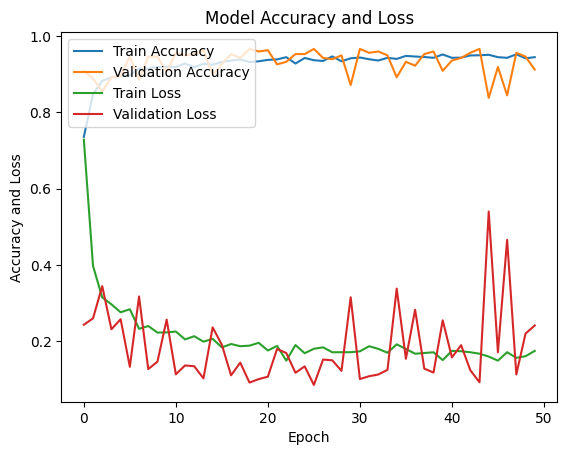

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [ ]:
scores = model.evaluate(test_ds)

history.params

history.history['accuracy']

38/38 [==============================] - 5s 84ms/step - loss: 0.3174 - accuracy: 0.9112


[0.7358333468437195,
 0.8479166626930237,
 0.8824999928474426,
 0.8916666507720947,
 0.8954166769981384,
 0.8974999785423279,
 0.9145833253860474,
 0.9145833253860474,
 0.918749988079071,
 0.9195833206176758,
 0.918749988079071,
 0.9279166460037231,
 0.9183333516120911,
 0.9270833134651184,
 0.925000011920929,
 0.9320833086967468,
 0.9354166388511658,
 0.9387500286102295,
 0.9316666722297668,
 0.9337499737739563,
 0.9375,
 0.9387500286102295,
 0.9445833563804626,
 0.9279166460037231,
 0.9424999952316284,
 0.9366666674613953,
 0.934583306312561,
 0.9466666579246521,
 0.9337499737739563,
 0.9416666626930237,
 0.9437500238418579,
 0.9391666650772095,
 0.9358333349227905,
 0.9429166913032532,
 0.9399999976158142,
 0.9479166865348816,
 0.9462500214576721,
 0.9449999928474426,
 0.9429166913032532,
 0.9516666531562805,
 0.9429166913032532,
 0.9433333277702332,
 0.9491666555404663,
 0.9495833516120911,
 0.9508333206176758,
 0.9445833563804626,
 0.9429166913032532,
 0.9520833492279053,
 0.94166

In [ ]:
history.history['val_accuracy']

[0.9087837934494019,
 0.8885135054588318,
 0.8547297120094299,
 0.8918918967247009,
 0.8952702879905701,
 0.9459459185600281,
 0.8851351141929626,
 0.9459459185600281,
 0.9459459185600281,
 0.9054054021835327,
 0.9560810923576355,
 0.9493243098258972,
 0.9527027010917664,
 0.962837815284729,
 0.8986486196517944,
 0.9256756901741028,
 0.9527027010917664,
 0.9425675868988037,
 0.9662162065505981,
 0.9594594836235046,
 0.962837815284729,
 0.9256756901741028,
 0.9324324131011963,
 0.9527027010917664,
 0.9527027010917664,
 0.9662162065505981,
 0.9425675868988037,
 0.9391891956329346,
 0.9493243098258972,
 0.8716216087341309,
 0.9662162065505981,
 0.9560810923576355,
 0.9594594836235046,
 0.9493243098258972,
 0.8918918967247009,
 0.9324324131011963,
 0.9222972989082336,
 0.9527027010917664,
 0.9594594836235046,
 0.9087837934494019,
 0.9358108043670654,
 0.9425675868988037,
 0.9560810923576355,
 0.9662162065505981,
 0.837837815284729,
 0.9189189076423645,
 0.8445945978164673,
 0.9560810923576

In [ ]:
history.history['loss']

[0.7284478545188904,
 0.3974495828151703,
 0.31499817967414856,
 0.2967984974384308,
 0.27599769830703735,
 0.28383350372314453,
 0.23261447250843048,
 0.23993287980556488,
 0.22273872792720795,
 0.22325746715068817,
 0.22545887529850006,
 0.20485839247703552,
 0.21327777206897736,
 0.19896875321865082,
 0.20634202659130096,
 0.18392349779605865,
 0.19275206327438354,
 0.18707683682441711,
 0.18842695653438568,
 0.19591201841831207,
 0.17583388090133667,
 0.18777263164520264,
 0.14923526346683502,
 0.1900845766067505,
 0.16863925755023956,
 0.18033726513385773,
 0.1840972602367401,
 0.1711391806602478,
 0.17131508886814117,
 0.1713428497314453,
 0.1735708862543106,
 0.18695323169231415,
 0.18013854324817657,
 0.16996674239635468,
 0.1919505000114441,
 0.17979227006435394,
 0.16734059154987335,
 0.1692323237657547,
 0.171129047870636,
 0.15066760778427124,
 0.17481310665607452,
 0.173862025141716,
 0.17117376625537872,
 0.16738837957382202,
 0.15984712541103363,
 0.14925026893615723,
 0

In [ ]:
history.history['val_loss']

[0.243312805891037,
 0.2599819302558899,
 0.3444942831993103,
 0.231418639421463,
 0.2577262222766876,
 0.13306336104869843,
 0.31748223304748535,
 0.1270291656255722,
 0.1464705914258957,
 0.2568361461162567,
 0.11336462944746017,
 0.13665054738521576,
 0.13446931540966034,
 0.1027580201625824,
 0.23645001649856567,
 0.1907169669866562,
 0.11077554523944855,
 0.1439598947763443,
 0.09177266061306,
 0.10072240978479385,
 0.10721268504858017,
 0.17979390919208527,
 0.16912618279457092,
 0.11744514852762222,
 0.1341940462589264,
 0.08557123690843582,
 0.15206322073936462,
 0.15009228885173798,
 0.12237845361232758,
 0.3152914047241211,
 0.10096628963947296,
 0.10836735367774963,
 0.11288224160671234,
 0.12499675154685974,
 0.3380209505558014,
 0.15397825837135315,
 0.28263258934020996,
 0.12833857536315918,
 0.11794950813055038,
 0.2548876106739044,
 0.1576828509569168,
 0.18982908129692078,
 0.1240096464753151,
 0.09253262728452682,
 0.5400582551956177,
 0.17111332714557648,
 0.46586340

In [ ]:
print("Accuracy: ", scores[1])
print("Loss: ", scores[0])

Accuracy:  0.9111841917037964
Loss:  0.3173861503601074


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

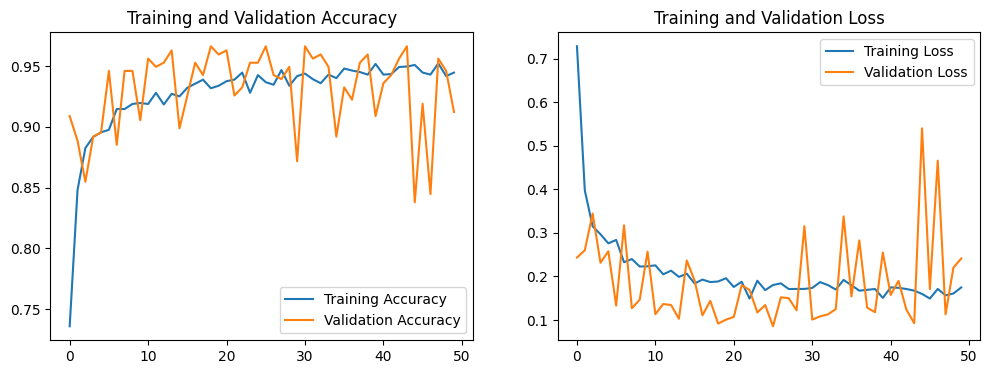

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

First image to predict
First image actual label: Potato___Late_blight
1/1 [==============================] - 9s 9s/step
[0.01136028 0.98743594 0.0012038 ]
Max Value: 1
Predicted Label: Potato___Late_blight


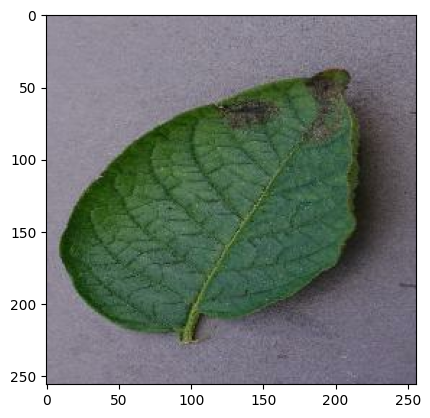

In [ ]:
for image_batch, label_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0]
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print(batch_prediction[0])
    print("Max Value:", np.argmax(batch_prediction[0]))
    print("Predicted Label:", class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 29ms/step


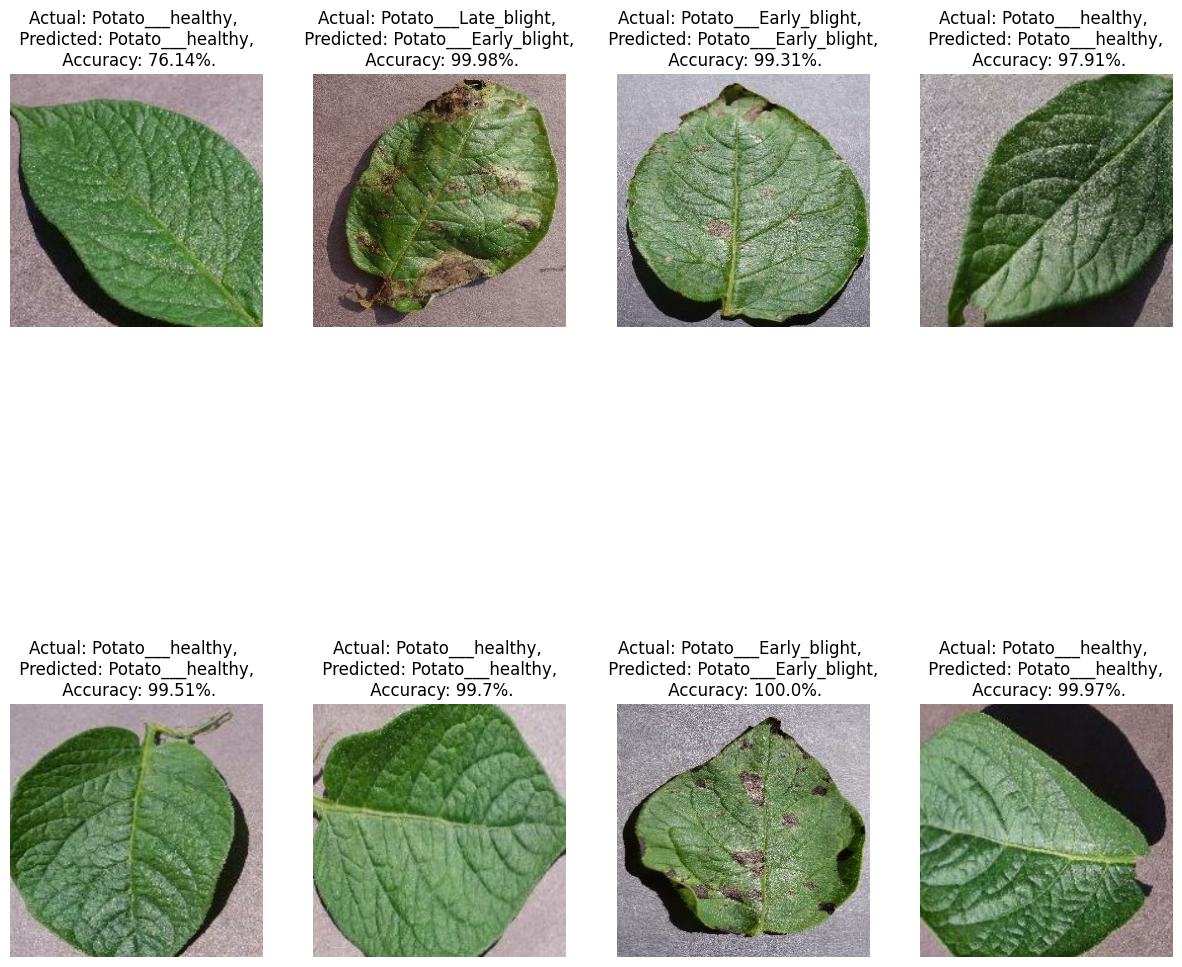

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Accuracy: {confidence}%.")  # Setting the title with actual class, predicted class, and confidence
        plt.axis("off")

In [ ]:
print("Accuracy: ", scores[1] * 100)

Accuracy:  91.11841917037964


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

f1 = f1_score(y_true, y_pred, average='weighted') * 100
precision = precision_score(y_true, y_pred, average='weighted') * 100
recall = recall_score(y_true, y_pred, average='weighted') * 100

print("F1 Score: ", f1)
print("Precision Score: ", precision)
print("Recall Score: ", recall)

38/38 [==============================] - 5s 80ms/step
F1 Score:  32.06265168850982
Precision Score:  31.905939644093078
Recall Score:  32.56578947368421


38/38 [==============================] - 3s 79ms/step


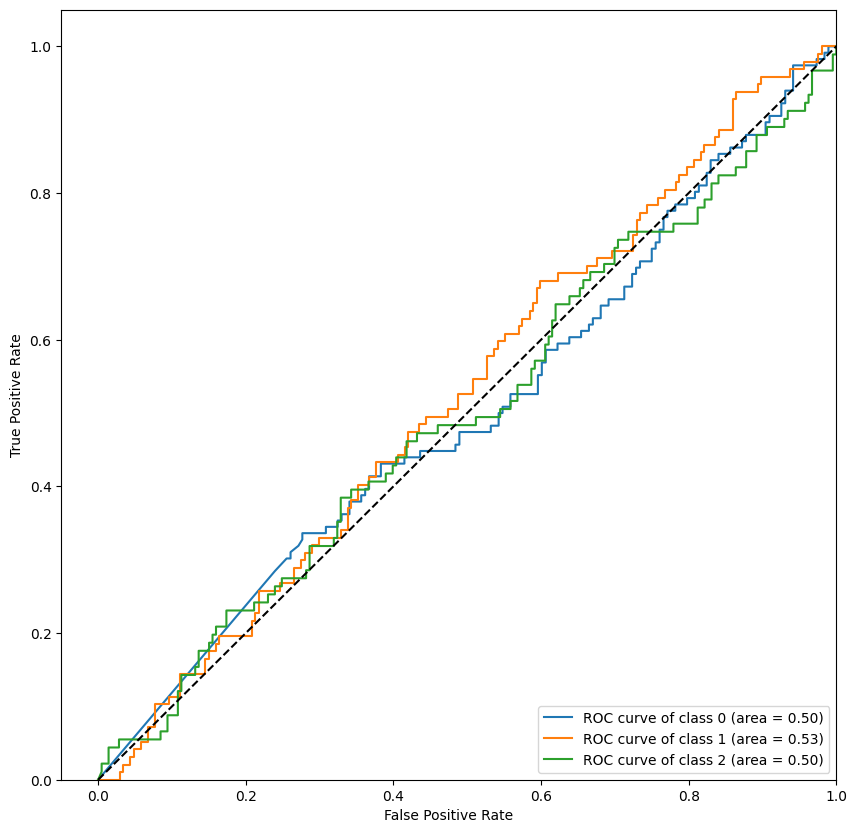

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test = label_binarize(y_true, classes=[0, 1, 2])
y_pred = model.predict(test_ds)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 10))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve of class {i} (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

38/38 [==============================] - 3s 79ms/step


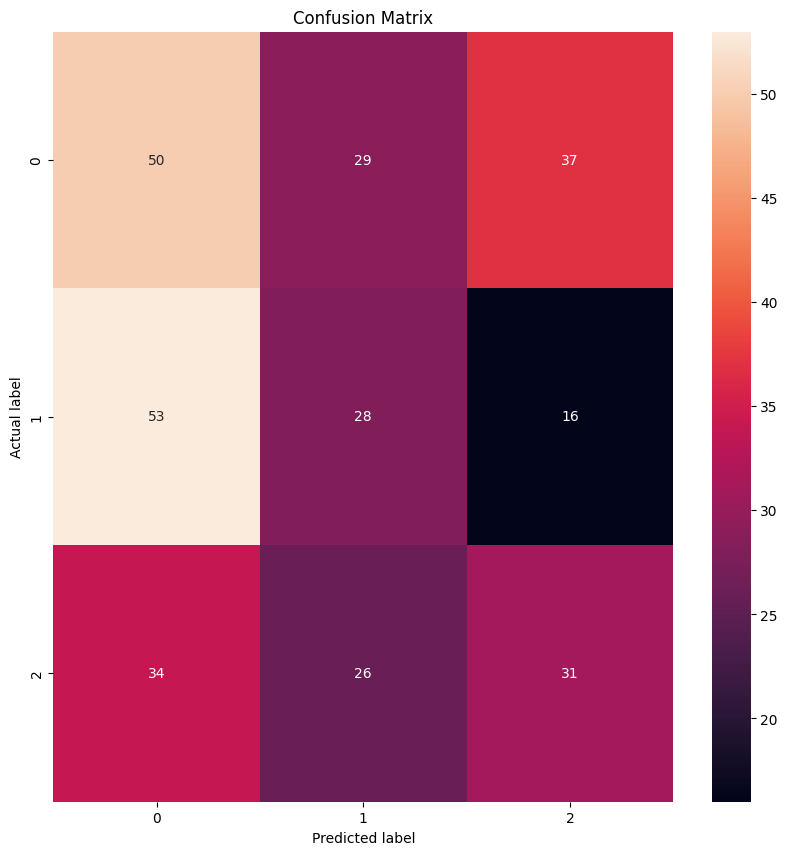

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Clear the TensorFlow session
tf.keras.backend.clear_session()